<a href="https://colab.research.google.com/github/jatbhoir/Customer-Lifetime-Value/blob/master/EVA_Case_Study_CLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#MAXIMIZING REVENUE AND RETENTION: LEVERAGING CLV INSIGHTS

---
#OBJECTIVE:
The primary goal of this, is to build a model custom tailored to Eva Solutions' Business Model for forcasting Customer Lifetime Value.

Focusing on the following:
1.   Enhancing Customer Retention
2.   Maximizing Revenue from the Existig Customers.
3.   Customer Behaviour and potential targeting techniques for each Loyalty Level



#IMPORTING PACKAGES

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#READING DATA

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#  Read the CSV file using the unicode_escape encoding
df = pd.read_csv('/content/drive/MyDrive/Classroom/SEM2/AMS TA/eCommerce Year 09-10.csv', encoding='unicode_escape')

In [4]:
# Display DataFrame
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,12/9/2010 20:01,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,12/9/2010 20:01,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,12/9/2010 20:01,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,12/9/2010 20:01,3.75,17530.0,United Kingdom


#DATA PREPROCESSING


In [5]:
# Checking Null Variables
df.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

As there are Null Variables in the ECommerce Dataset [CustomerID, Desc.], We need to remove these Observations.

In [6]:
df.dropna(inplace = True) # Droping all NA Observations
df = df[~df['Invoice'].str.contains('C', na = False)]
df = df[df['Quantity'] > 0] # Checking for QTY
df = df[df['Price'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) # Formating 'InvoiceDate' from str to DateTime
df['TotalRevenue'] = df['Quantity'] * df['Price'] # Creating Column with TotalRevenue
df.head() # Display Top 5 values

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalRevenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


#EXPLORATORY ANALYSIS

Exploratory analysis helps us to answer questions such as:

* What are the most purchased products in the platform?
* People from which country are transacting more?
* Which hour of the day, day of the week is when the most transactions happen?
* What is the trend of transactions for the given period?

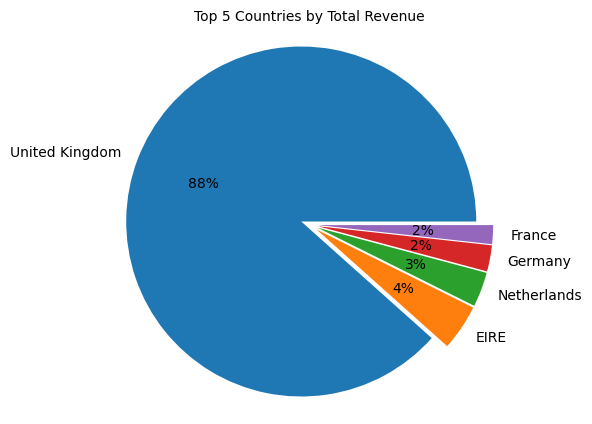

In [7]:
# @title Top countries by sales value
top_country = df.groupby('Country')['TotalRevenue'].sum().sort_values(ascending = False)[:10]
labels = top_country[:5].index
size = top_country[:5].values

plt.figure(figsize=(5, 5))
plt.pie(size, labels=labels, explode=[0.05]*5, autopct='%1.0f%%')
plt.title("Top 5 Countries by Total Revenue", size=10)
plt.axis('equal')
plt.show()


#AGGREGATE MODEL (HISTORICAL APPROACH)

---


In [8]:
# Data Based on grouping around 'CustomerID' & Aggregating Metrics (data)

MDate = df['InvoiceDate'].max() # Setting the Latest Date as Maximum
# CDate = dt.datetime.now() # Testing 'What will happen if we try todays date'

# Calculating Recency, Frequency, Monetary.
data = df.groupby('Customer ID').aggregate(
    {
        'InvoiceDate': lambda date: (MDate - date.min()).days, # Recency: Diff in days from last purchase
        'Invoice': lambda inv: len(inv), # Frequncy: No. of times recorded purchases
        'TotalRevenue': lambda tr: tr.sum(), # Monetary: Total revenue generated by customer
    }
)

# Changing Column Names
data.columns = ['Age', 'No_Transactions', 'TotalRevenue']

In [9]:
# Descriptive Stats
display(data.describe())

,Age,No_Transactions,TotalRevenue
count,4312.000000,4312.000000,4312.000000
mean,224.494434,94.541744,2048.238236
std,118.909291,202.046410,8914.481280
min,0.000000,1.000000,2.950000
25%,116.000000,18.000000,307.987500
50%,252.000000,44.000000,706.020000
75%,328.000000,102.000000,1723.142500
max,373.000000,5570.000000,349164.350000


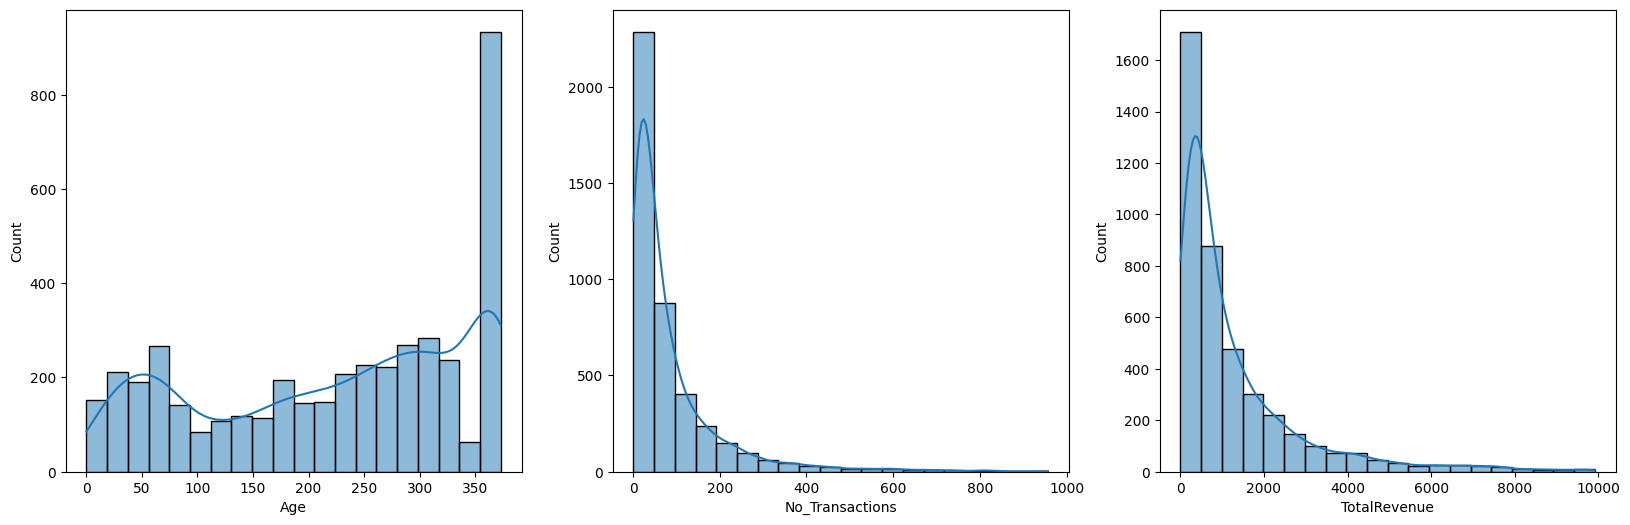

In [10]:
# Distributions of Recency, Frequency, and Monetary features
# Here we will filter out the extreme values in the Frequency and Monetary columns to avoid the skewness the distribution
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(data.Age, bins = 20, ax = ax[0], kde = True)
sns.histplot(data[data['No_Transactions']<1000]['No_Transactions'], bins= 20, ax = ax[1], kde = True)
sns.histplot(data[data['TotalRevenue']<10000]['TotalRevenue'], bins= 20, ax = ax[2], kde = True)
plt.show()

#RFM SEGMENTATION

In [11]:
# Define quartile thresholds for Recency, Frequency, and Monetary
R_Thresholds = [0, 30, 60, 90, np.inf]  # Define thresholds for Recency (in days)
F_Thresholds = [1, 2, 5, 10, np.inf]     # Define thresholds for Frequency
M_Thresholds = [0, 100, 500, 1000, np.inf]# Define thresholds for Monetary (in currency units)

rfm = pd.DataFrame()

# Assign quartile labels based on thresholds
rfm['Recency'] = pd.cut(data['Age'], bins = R_Thresholds, labels=[4, 3, 2, 1])
rfm['Frequency'] = pd.cut(data['No_Transactions'], bins = F_Thresholds, labels=[1, 2, 3, 4])
rfm['Monetary'] = pd.cut(data['TotalRevenue'], bins = M_Thresholds, labels=[1, 2, 3, 4])
# 4: Quartile 4 - Highest Value, 3: Quartile 3 - Second Highest Value,
# 2: Quartile 2 - Second Lowest Value, 1: Quartile 1 - Lowest Value.

# Combine RFM values to create segments
rfm['RFM_Segment'] = rfm['Recency'].astype(str) + rfm['Frequency'].astype(str) + rfm['Monetary'].astype(str)

# Calculate RFM score
rfm['RFM_Score'] = rfm[['Recency', 'Frequency', 'Monetary']].sum(axis=1)

# Verify the resulting dataframe
rfm.head()


/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/base.py:513: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)


,Recency,Frequency,Monetary,RFM_Segment,RFM_Score
Customer ID,,,,,
12346.0,1,4,2,142,7
12347.0,3,4,4,344,11
12348.0,2,4,2,242,8
12349.0,1,4,4,144,9
12351.0,4,4,2,442,10


In [12]:
# Loyalty levels
L_Thresholds = [0, 2, 5, 10, np.inf]
loyalty = ['Bronze', 'Silver', 'Gold', 'Platinum']
rfm['Loyalty_Level'] = pd.cut(rfm['RFM_Score'], bins = L_Thresholds , labels = loyalty)
rfm

,Recency,Frequency,Monetary,RFM_Segment,RFM_Score,Loyalty_Level
Customer ID,,,,,,
12346.0,1,4,2,142,7,Gold
12347.0,3,4,4,344,11,Platinum
12348.0,2,4,2,242,8,Gold
12349.0,1,4,4,144,9,Gold
12351.0,4,4,2,442,10,Gold
...,...,...,...,...,...,...
18283.0,1,4,3,143,8,Gold
18284.0,2,4,2,242,8,Gold
18285.0,1,4,2,142,7,Gold


In [34]:
behaviour = rfm.groupby('Loyalty_Level')[['Recency', 'Frequency', 'Monetary', 'RFM_Score']].mean()
behaviour

<ipython-input-34-5964a194fec4>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  behaviour = rfm.groupby('Loyalty_Level')[['Recency', 'Frequency', 'Monetary', 'RFM_Score']].mean()


,RFM_Score
Loyalty_Level,
Bronze,NaN
Silver,4.470588
Gold,8.304293
Platinum,11.219048


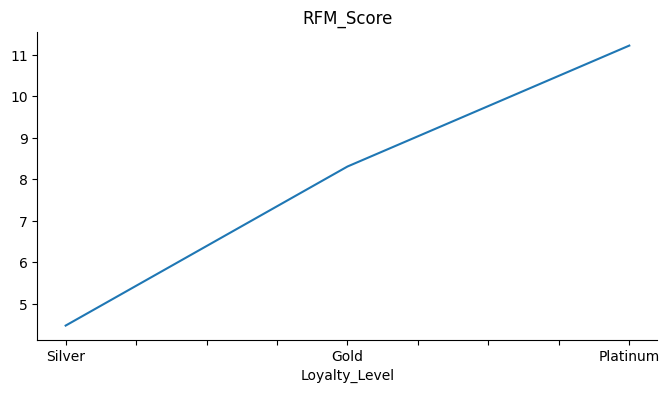

In [14]:
from matplotlib import pyplot as plt
behaviour['RFM_Score'].plot(kind='line', figsize=(8, 4), title='RFM_Score')
plt.gca().spines[['top', 'right']].set_visible(False)

#Customer Lifetime Value
---
**CLV** = Average Purchase Value * Average Purchase Frequency * Average Customer Lifespan * Gross Margin


In [15]:
# Calculating Average Order Value
data['AverageOrderValue'] = data['TotalRevenue'] / data['No_Transactions']
data.head()

,Age,No_Transactions,TotalRevenue,AverageOrderValue
Customer ID,,,,
12346.0,360,33,372.86,11.298788
12347.0,39,71,1323.32,18.638310
12348.0,73,20,222.16,11.108000
12349.0,224,102,2671.14,26.187647
12351.0,10,21,300.93,14.330000


In [16]:
AverageOrderValue = data['TotalRevenue'].sum() / data['No_Transactions'].sum()
tr, nt = data['TotalRevenue'].sum(), data['No_Transactions'].sum()
print(f'Average Purchase Value: ${round(AverageOrderValue, 2)}, TotalRevenue: ${tr}, Total Transactions: {nt}')

Average Purchase Value: $21.66, TotalRevenue: $8832003.274, Total Transactions: 407664


In [17]:
# Calculate Purchase Frequency
PurchaseFrequency = np.mean(data['No_Transactions'])
# PurchaseFrequency = data['No_Transactions'].sum() / len(data)
print(f'Purchase Frequency: {round(PurchaseFrequency, 2)}, len(data): {len(data)}')

Purchase Frequency: 94.54, len(data): 4312


In [18]:
# Calculate Retention Rate by removing one-time purchases from dataset
RetentionRate = data[data['No_Transactions'] > 1].shape[0]/data.shape[0]  # data[(data['No of Transactions'] > 1)] .shape to convert array/table
print(f'Retention Rate: {round(RetentionRate, 2)}%')

Retention Rate: 0.98%


In [19]:
# Calculate Churn Rate
ChurnRate = (1 - RetentionRate)
print(f'Churn Rate: {round(ChurnRate, 2)}%')

Churn Rate: 0.02%


In [20]:
# Gross Margin
GrossMargin = 0.60 # Change Accordingly [Here took 60%]

In [21]:
# Calculate Average Customer Lifespan
AverageCustomerLifespan = 1/ChurnRate
print(f'Average Customer Lifespan: {round(AverageCustomerLifespan, 2)}')

Average Customer Lifespan: 47.38


In [22]:
# Calculate Customer Lifetime Value
CLV = (AverageOrderValue * GrossMargin * AverageCustomerLifespan) #/ data.shape[0]
print(f'Customer Lifetime Value: ${round(CLV, 2)}')

Customer Lifetime Value: $615.95


#PER CUSTOMER CLV

In [32]:
data = data[data['No_Transactions'] > 1]
data['AverageOrderValue'] = round((data['TotalRevenue'] / data['No_Transactions']), 2)
data['CLV'] = round((data['AverageOrderValue'] * GrossMargin * AverageCustomerLifespan), 2)
data.head()

,Age,No_Transactions,TotalRevenue,AverageOrderValue,CLV
Customer ID,,,,,
12346.0,360,33,372.86,11.30,321.27
12347.0,39,71,1323.32,18.64,529.95
12348.0,73,20,222.16,11.11,315.87
12349.0,224,102,2671.14,26.19,744.60
12351.0,10,21,300.93,14.33,407.41


In [24]:
top = data.sort_values(by = 'CLV', ascending = False)
top.head()

,Age,No_Transactions,TotalRevenue,AverageOrderValue,CLV
Customer ID,,,,,
15760.0,265,2,13916.34,6958.17,197826.13
15202.0,55,3,6001.49,2000.50,56875.75
12737.0,133,2,3710.50,1855.25,52746.18
17940.0,371,17,26286.75,1546.28,43961.93
14028.0,185,9,10396.50,1155.17,32842.37


In [25]:
lst = data.sort_values(by = 'CLV', ascending = True)
lst.head()

,Age,No_Transactions,TotalRevenue,AverageOrderValue,CLV
Customer ID,,,,,
17816.0,359,38,75.76,1.99,56.58
15503.0,361,53,120.06,2.27,64.54
17916.0,368,19,43.87,2.31,65.68
15583.0,11,46,107.86,2.34,66.53
14684.0,25,98,232.27,2.37,67.38


In [26]:
df.loc[df['Customer ID'] == 15760.0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalRevenue
129903,501766,M,Manual,1,2010-03-19 11:35:00,6958.17,15760.0,Norway,6958.17
129987,501768,M,Manual,1,2010-03-19 11:45:00,6958.17,15760.0,Norway,6958.17


# CLV BASED ON COUNTRY

In [27]:
# Data Based on grouping around 'Country' & Aggregating Metrics (data)

country = df.groupby('Country').aggregate(
    {
        'InvoiceDate': lambda date: (MDate - date.min()).days, # Diff in days from last purchase
        'Invoice': lambda inv: len(inv), # No. of times recorded purchases
        'TotalRevenue': lambda tr: tr.sum(), # Total revenue generated by customer
    }
)

country.columns = ['Age', 'No_Transactions', 'TotalRevenue']
country = country.sort_values(by = 'TotalRevenue', ascending = False)
country.head()

,Age,No_Transactions,TotalRevenue
Country,,,
United Kingdom,373,370929,7414755.963
EIRE,373,8507,356085.210
Netherlands,372,2729,268786.000
Germany,373,7654,202395.321
France,373,5470,146215.420


In [28]:

country['AverageOrderValue'] = round((country['TotalRevenue'] / country['No_Transactions']), 2)
country['CLV'] = round((country ['AverageOrderValue'] * GrossMargin * AverageCustomerLifespan), 2)
country = country.sort_values(by = 'CLV', ascending = False)
country.head()

,Age,No_Transactions,TotalRevenue,AverageOrderValue,CLV
Country,,,,,
Denmark,372,418,50906.85,121.79,3462.58
Netherlands,372,2729,268786.00,98.49,2800.15
Norway,367,365,23944.18,65.60,1865.06
Sweden,365,868,53171.39,61.26,1741.67
Japan,328,164,9722.02,59.28,1685.38


<Axes: xlabel='Country', ylabel='CLV'>

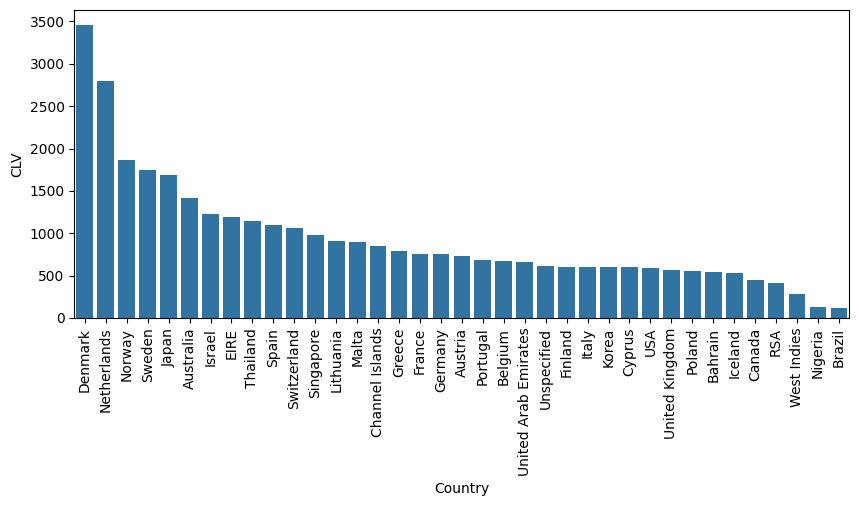

In [29]:
# @title CLV ~ Country
fig = plt.figure(figsize = (10, 4))
plt.xticks(rotation = 90)
sns.barplot(x = 'Country', y = 'CLV', data = country)



<Axes: xlabel='Country', ylabel='TotalRevenue'>

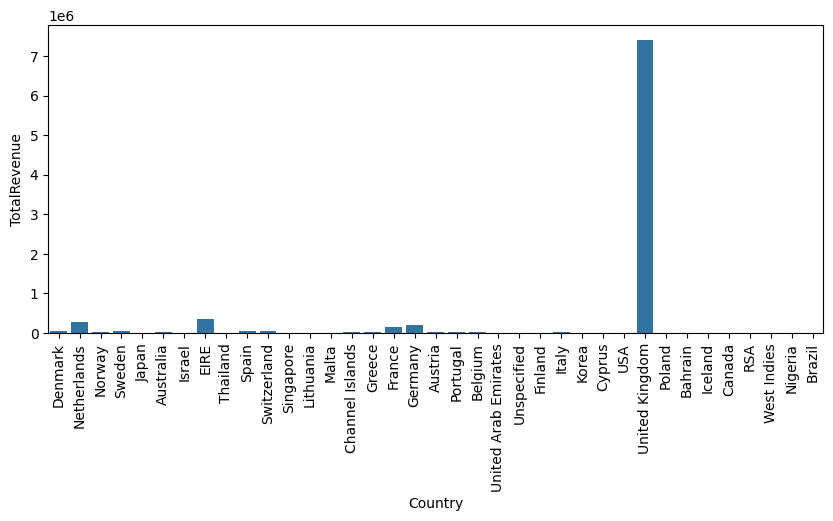

In [30]:
# @title Revenue ~ Country
fig = plt.figure(figsize = (10, 4))
plt.xticks(rotation = 90)
sns.barplot(x = 'Country', y = 'TotalRevenue', data = country)

In [31]:
# data.to_excel('/content/drive/MyDrive/output.xlsx', index = True)